# Register Model and Develop Model Driver

In this notebook, we register the model trained earlier and develop the model driver that will be used in the web service creation.

In [ ]:
%matplotlib inline

import azureml.core
from azureml.core import Workspace
from azureml.core.model import Model
import tensorflow as tf

import sys
import os
sys.path.append("../models/research/") # Modify to point to your tensorflow models directory
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util
from matplotlib import pyplot as plt

## Register Model

In [1]:
# Check core SDK version number
print("SDK version:", azureml.core.VERSION)

SDK version: 1.0.23


In [2]:
ws = Workspace.from_config()
# print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Found the config file in: /datadrive/OutOfStockDemo/.azureml/config.json


In [4]:
library_version = "tensorflow "+ tf.__version__

model = Model.register(model_path = "export_maskrcnn/frozen_inference_graph.pb",
                       model_name = "maskrcnn_outofstock_model",
                       tags = {'area': "CoputerVison", 'type': "ObjectDetection", 'version': library_version},
                       description = "MaskRCNN model to predict out of stock products",
                       workspace = ws)

In [5]:
for m in Model.list(workspace=ws):
    print("Name:", m.name,"\tVersion:", m.version, "\tDescription:", m.description, m.tags)

Name: maskrcnn_outofstock_model 	Version: 3 	Description: MaskRCNN model to predict out of stock products {'area': 'CoputerVison', 'type': 'ObjectDetection', 'version': 'tensorflow 1.12.0'}
Name: maskrcnn_outofstock_model 	Version: 2 	Description: MaskRCNN model to predict out of stock products {'area': 'CoputerVison', 'type': 'ObjectDetection', 'version': 'tensorflow 1.12.0'}
Name: out_of_stock_model 	Version: 3 	Description: SSD model to predict out of stock products {'area': 'CoputerVison', 'type': 'ObjectDetection', 'version': 'tensorflow 1.12.0'}
Name: out_of_stock_model 	Version: 2 	Description: SSD model to predict out of stock products {'area': 'CoputerVison', 'type': 'ObjectDetection', 'version': 'tensorflow 1.12.0'}
Name: resnet_model 	Version: 2 	Description: resnet 152 model {'model': 'dl', 'framework': 'resnet'}
Name: lgbm_model_1000 	Version: 1 	Description: None {}
Name: mask_rcnn_multidw_0010.h5 	Version: 1 	Description: MaskRCNN model to detect voids {'area': 'ObjectDe

In [7]:
print(model.name, model.description, model.version, sep = '\t')

maskrcnn_outofstock_model	MaskRCNN model to predict out of stock products	3


In [17]:
from dotenv import set_key, get_key, find_dotenv

In [18]:
env_path = find_dotenv(raise_error_if_not_found=True)

In [19]:
set_key(env_path, "model_name", model.name)

(True, 'model_name', 'maskrcnn_outofstock_model')

## Develop Model Driver

Here we save the model driver as a script.

In [8]:
%%writefile detect.py

from azureml.core.model import Model
from azureml.contrib.services.aml_request import rawhttp
from PIL import Image
import numpy as np
import tensorflow as tf
import json

def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8).tolist()
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0].tolist()
      output_dict['detection_scores'] = output_dict['detection_scores'][0].tolist()
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0].tolist()
  return output_dict

def init():   
    global detection_graph
    
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        model_path =  Model.get_model_path("maskrcnn_outofstock_model")
        with tf.gfile.GFile(model_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
            
@rawhttp
def run(request):
    image = Image.open(request.files["image"])
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    return(json.dumps(output_dict))     

Overwriting detect.py


In [9]:
%run detect.py

We will overwrite some functions for local debugging.

In [10]:
from azureml.core.model import Model
from azureml.contrib.services.aml_request import rawhttp
from PIL import Image
import numpy as np
import tensorflow as tf
import json

def init():   
    global detection_graph
    
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
#         model_path =  Model.get_model_path("maskrcnn_outofstock_model")
        model_path =  Model.get_model_path("export_maskrcnn/frozen_inference_graph.pb")
        with tf.gfile.GFile(model_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
            
@rawhttp
def run(request):
#     image = Image.open(request.files)
    image = Image.open(request["image"])
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    return(json.dumps(output_dict))            

In [11]:
init()

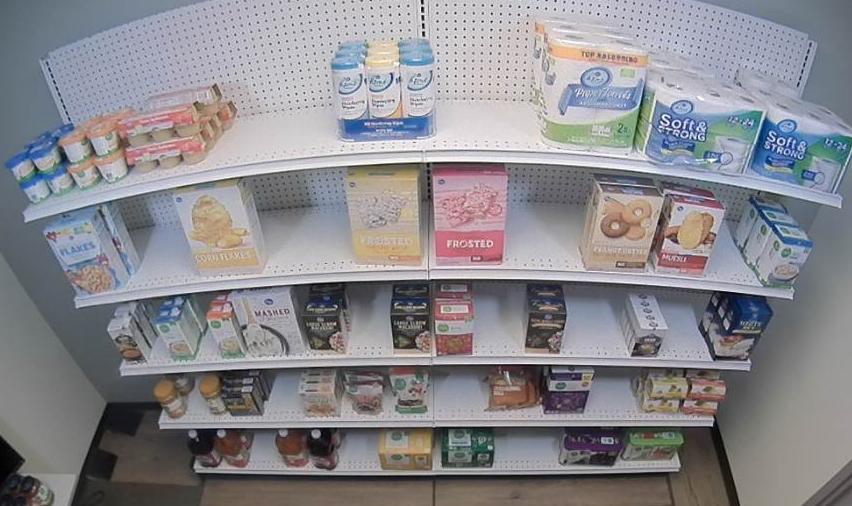

In [12]:
request_files = {"image": open('./annotated/runeightft3/1555539843.1911.jpg', "rb")}
image = Image.open(request_files["image"])
image

In [13]:
output_dict = json.loads(run(request_files))
image_np = load_image_into_numpy_array(image)

In [14]:
PATH_TO_LABELS =  './stockout_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

IMAGE_SIZE = (24, 18)

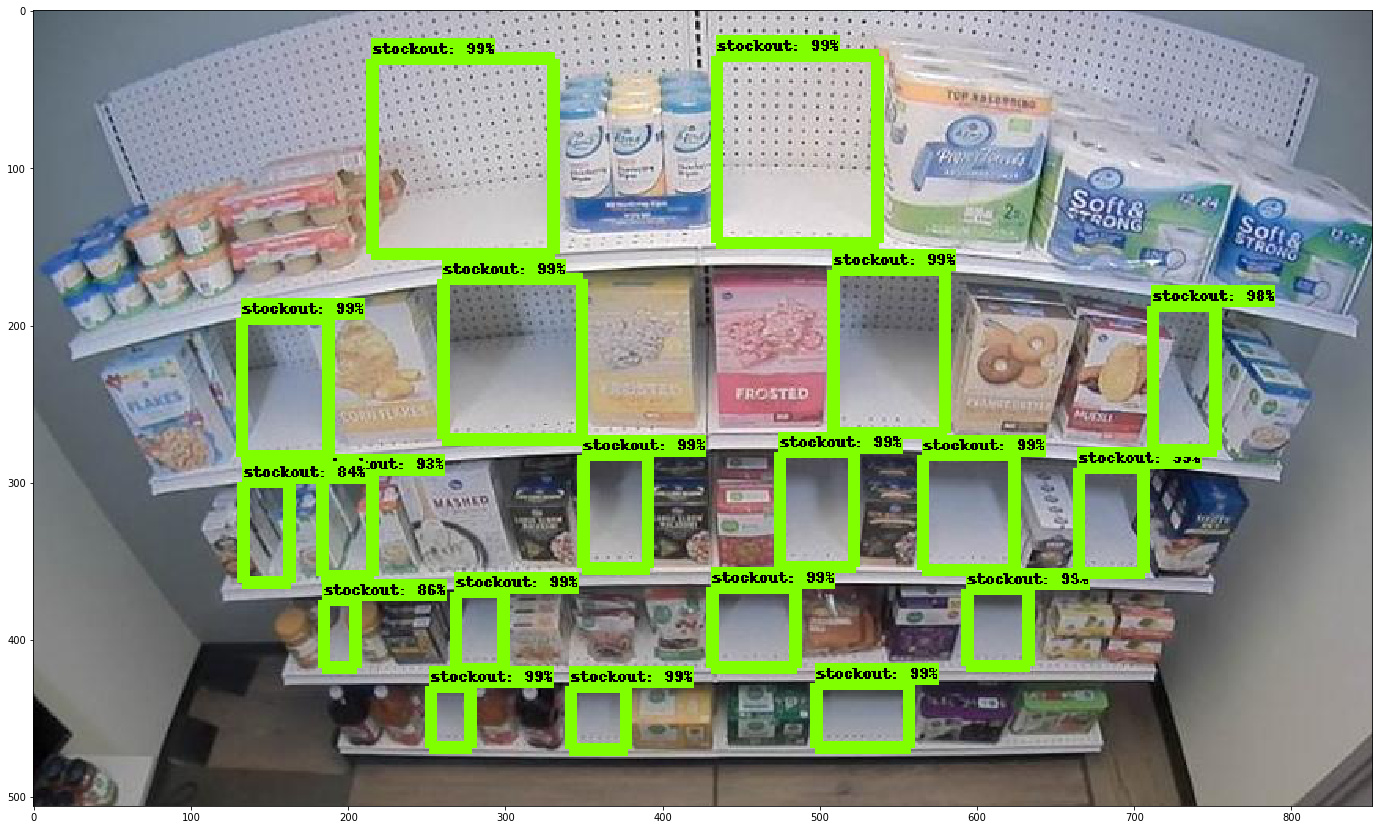

In [16]:
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    np.array(output_dict['detection_boxes']),
    np.array(output_dict['detection_classes']),
    np.array(output_dict['detection_scores']),
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    max_boxes_to_draw=100,
    min_score_thresh=.5,
    use_normalized_coordinates=True,
    line_thickness=8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)